In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [224]:
sns.set_style('darkgrid')

# Data and helper functions

In [255]:
df_national = gpd.read_file('../../Data/flood_ipc_seasonal_national.gpkg')
df_national = df_national.drop('level_0', 1)

In [256]:
df_national['mean_ipc_next'] = df_national.groupby(df_national['Name'])['mean_ipc'].shift(-1)
df_national['mean_ipc_nextnext'] = df_national.groupby(df_national['Name'])['mean_ipc'].shift(-2)
df_national['mean_ipc_nextnextnext'] = df_national.groupby(df_national['Name'])['mean_ipc'].shift(-3)

In [199]:
df_national.describe().T

,count,mean,std,min,25%,50%,75%,max
index,625.0,7.488000e+00,4.619524e+00,0.0,3.000000e+00,7.000000e+00,1.100000e+01,1.500000e+01
ID_0,625.0,1.604288e+02,6.748921e+01,38.0,1.180000e+02,1.530000e+02,2.180000e+02,2.560000e+02
OBJECTID_1,586.0,1.678840e+02,6.185055e+01,22.0,1.480000e+02,1.640000e+02,2.200000e+02,2.530000e+02
POP2000,586.0,2.241027e+07,2.842379e+07,0.0,8.777879e+06,1.135080e+07,2.330016e+07,1.138618e+08
SQKM,586.0,8.281473e+05,5.655375e+05,0.0,2.737192e+05,7.886289e+05,1.168002e+06,2.337027e+06
POPSQKM,586.0,3.677470e+01,3.863255e+01,0.0,6.751101e+00,1.672991e+01,5.555615e+01,1.248431e+02
Year,625.0,2.014274e+03,3.045124e+00,2009.0,2.012000e+03,2.014000e+03,2.017000e+03,2.020000e+03
Month,625.0,5.848000e+00,3.475777e+00,1.0,2.000000e+00,6.000000e+00,1.000000e+01,1.200000e+01
no_flood_events,625.0,4.096000e-01,7.649602e-01,0.0,0.000000e+00,0.000000e+00,1.000000e+00,6.000000e+00
no_dam_breaks,625.0,1.600000e-03,4.000000e-02,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


In [184]:
def baseline_model_table(df, y, cov_list, countries, groups = None):
    
    colnames = ['Country']
    for cov in cov_list:
        colnames.append('effect_size_{}'.format(cov))
        colnames.append('se_{}'.format(cov))
        colnames.append('p-value_{}'.format(cov))
    
    model_formula = '{} ~ '.format(y) + ' + '.join(cov_list)
    
    results_dict = {i : [] for i in colnames}
    
    for country in countries:
        df_select = df.loc[df['Name'] == country].reset_index()
        
        if groups == None:
            model = smf.ols(model_formula, data = df_select,
                       missing = 'drop').fit()
        else:
            model = smf.mixedlm(model_formula, data = df_select, groups = groups,
                               missing = 'drop').fit()
        
        effects = [model.params[j] for j in range(1, len(cov_list) + 1)]
        bses = [model.bse[j] for j in range(1, len(cov_list) + 1)]
        pvalues = [model.pvalues[j] for j in range(1, len(cov_list) + 1)]
        
        
        results_dict['Country'].append(country)


        for j, cov in enumerate(cov_list):

            results_dict['effect_size_{}'.format(cov)].append(effects[j])
            results_dict['se_{}'.format(cov)].append(bses[j])
            results_dict['p-value_{}'.format(cov)].append(pvalues[j])

    
    results_table = pd.DataFrame(data = results_dict, columns = colnames)
    return(results_table)

In [170]:
def sensitivity_analysis_seasons(df, y, cov_list, country, groups = None):
    
    colnames = ['Country', 'Year', 'Month']
    for cov in cov_list:
        colnames.append('effect_size_{}'.format(cov))
        colnames.append('se_{}'.format(cov))
        colnames.append('p-value_{}'.format(cov))
    
    model_formula = '{} ~ '.format(y) + ' + '.join(cov_list)
    
    df_select = df.loc[df['Name'] == country].reset_index()
    
    results_dict = {i : [] for i in colnames}
    
    for i, row in df_select.iterrows():
        df_select_loo = df_select.drop(i, axis = 0)
        
        if groups == None:
            model = smf.ols(model_formula, data = df_select_loo,
                       missing = 'drop').fit()
        else:
            model = smf.mixedlm(model_formula, data = df_select_loo, groups = groups,
                               missing = 'drop').fit()
        
        effects = [model.params[j] for j in range(1, len(cov_list) + 1)]
        bses = [model.bse[j] for j in range(1, len(cov_list) + 1)]
        pvalues = [model.pvalues[j] for j in range(1, len(cov_list) + 1)]
        
        
        results_dict['Country'].append(row['Name'])
        results_dict['Year'].append(row['Year'])
        results_dict['Month'].append(row['Month'])


        for j, cov in enumerate(cov_list):

            results_dict['effect_size_{}'.format(cov)].append(effects[j])
            results_dict['se_{}'.format(cov)].append(bses[j])
            results_dict['p-value_{}'.format(cov)].append(pvalues[j])

    
    results_table = pd.DataFrame(data = results_dict, 
                                 columns = colnames)
    return(results_table)

## Mixed effect model for all countries

### Time 0 (i.e., corresponding to IPC reporting period immediately following flood events) model:

In [293]:
model0 = smf.mixedlm('mean_ipc ~ no_flood_events + total_flood_dur_days + total_flood_area_km2', 
                    data = df_national, groups = 'Name', missing = 'drop').fit()
model0.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:                MixedLM   Dependent Variable:   mean_ipc 
No. Observations:     620       Method:               REML     
No. Groups:           16        Scale:                0.1189   
Min. group size:      38        Log-Likelihood:       -272.5358
Max. group size:      39        Converged:            Yes      
Mean group size:      38.8                                     
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             1.520    0.091 16.687 0.000  1.342  1.699
no_flood_events       0.013    0.033  0.393 0.694 -0.052  0.079
total_flood_dur_days -0.003    0.001 -2.181 0.029 -0.006 -0.000
total_flood_area_km2  0.000    0.000  2.686 0.007  0.000  0.000
Name Var              0.129    0.141                           
===============================================================

"""

We see that both total flood duration and area of extent across a particular country and season have small but significant effects on mean IPC ratings in the seasons immediately following them.

### Time 1 model:

In [294]:
model1 = smf.mixedlm('mean_ipc_next ~ no_flood_events + total_flood_dur_days + total_flood_area_km2 + mean_ipc', 
                    data = df_national, groups = 'Name', missing = 'drop').fit()
model1.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:              MixedLM  Dependent Variable:  mean_ipc_next
No. Observations:   599      Method:              REML         
No. Groups:         16       Scale:               0.0670       
Min. group size:    36       Log-Likelihood:      -83.6827     
Max. group size:    38       Converged:           Yes          
Mean group size:    37.4                                       
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             0.514    0.059  8.711 0.000  0.398  0.630
no_flood_events       0.049    0.028  1.774 0.076 -0.005  0.103
total_flood_dur_days -0.002    0.001 -2.091 0.037 -0.005 -0.000
total_flood_area_km2 -0.000    0.000 -1.139 0.255 -0.000  0.000
mean_ipc              0.656    0.034 19.586 0.000  0.591  0.722
Name Var              0.012    0.022                           
===============================================================

"""

Flood duration seems to have a small but significant negative influence on mean IPC rating in the season following flood events.

### Time 2 model:

In [295]:
model2 = smf.mixedlm('mean_ipc_nextnext ~ no_flood_events + total_flood_dur_days + total_flood_area_km2 + mean_ipc_next', 
                    data = df_national, groups = 'Name', missing = 'drop').fit()
model2.summary()

/Users/connor/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/connor/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
/Users/connor/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/connor/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
/Users/connor/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/connor/opt/anaconda

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:            MixedLM Dependent Variable: mean_ipc_nextnext
No. Observations: 583     Method:             REML             
No. Groups:       16      Scale:              0.0651           
Min. group size:  35      Log-Likelihood:     -72.9789         
Max. group size:  37      Converged:          No               
Mean group size:  36.4                                         
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             0.458    0.059  7.777 0.000  0.342  0.573
no_flood_events       0.057    0.028  2.034 0.042  0.002  0.111
total_flood_dur_days -0.000    0.001 -0.061 0.951 -0.002  0.002
total_flood_area_km2  0.000    0.000  2.844 0.004  0.000  0.000
mean_ipc_next         0.673    0.034 19.619 0.000  0.606  0.740
Name Var              0.010    0.020                           
===============================================================

"""

Here, 2 seasons after flooding, the number of flood events and their total area of extent appear to significantly correlate with mean IPC ratings. The number of flood events, specifically, correlates with higher mean IPC ratings 2 seasons after they occur.

### Time 3 model:

In [296]:
model3 = smf.mixedlm('mean_ipc_nextnextnext ~ no_flood_events + total_flood_dur_days + total_flood_area_km2 + mean_ipc_nextnext', 
                    data = df_national, groups = 'Name', missing = 'drop').fit()
model3.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
===================================================================
Model:            MixedLM Dependent Variable: mean_ipc_nextnextnext
No. Observations: 567     Method:             REML                 
No. Groups:       16      Scale:              0.0670               
Min. group size:  34      Log-Likelihood:     -82.4671             
Max. group size:  36      Converged:          Yes                  
Mean group size:  35.4                                             
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.537    0.062  8.711 0.000  0.417  0.658
no_flood_events           0.008    0.028  0.296 0.767 -0.046  0.063
total_flood_dur_days     -0.001    0.001 -0.587 0.557 -0.003  0.002
total_flood_area_km2      0.000    0.000  2.554 0.011  0.000  0.000
mean_ipc_nextnext         0.632    0.035 17.872 0.000  0.563  0.701
Name Var                  0.015    0.027                           
===================================================================

"""

In [297]:
model3.params

Intercept               5.374682e-01
no_flood_events         8.228046e-03
total_flood_dur_days   -6.888495e-04
total_flood_area_km2    2.982452e-07
mean_ipc_nextnext       6.320704e-01
Name Var                2.247248e-01
dtype: float64

Three seasons after flooding occurs, flood extent seems to have a significant but negligible correlation (effect size = 2.982452e-07) with mean IPC rating.

# Identifying countries with internally significant flood responses across all seasons

Below, I build multivariate linear models corresponding to the four mixed models above, but this time separately for each country in our dataset. For each recording period/season, I've isolated the countries where at least one of the relationships between the covariates and mean IPC rating of the selected time period is significant and presented their main parameters in tables.

In [262]:
covariates_0 = ['no_flood_events', 'total_flood_area_km2', 'total_flood_dur_days']
covariates_1 = ['no_flood_events', 'total_flood_area_km2', 'total_flood_dur_days', 'mean_ipc']
covariates_2 = ['no_flood_events', 'total_flood_area_km2', 'total_flood_dur_days', 'mean_ipc_next']
covariates_3 = ['no_flood_events', 'total_flood_area_km2', 'total_flood_dur_days', 'mean_ipc_nextnext']

baseline_0 = baseline_model_table(df_national, 'mean_ipc', covariates_0, country_names)
baseline_1 = baseline_model_table(df_national, 'mean_ipc_next', covariates_0, country_names)
baseline_2 = baseline_model_table(df_national, 'mean_ipc_nextnext', covariates_0, country_names)
baseline_3 = baseline_model_table(df_national, 'mean_ipc_nextnextnext', covariates_0, country_names)

### Time 0

In [273]:
time_0 = baseline_0.loc[(baseline_0['p-value_no_flood_events'] < 0.05) | 
              (baseline_0['p-value_total_flood_area_km2'] < 0.05) |
              (baseline_0['p-value_total_flood_dur_days'] < 0.05)]

time_0_sig_countries = time_0.Country.unique()
time_0

,Country,effect_size_no_flood_events,se_no_flood_events,p-value_no_flood_events,effect_size_total_flood_area_km2,se_total_flood_area_km2,p-value_total_flood_area_km2,effect_size_total_flood_dur_days,se_total_flood_dur_days,p-value_total_flood_dur_days
7,Niger,-0.186437,0.167791,0.274089,1.098382e-06,3.763494e-07,0.006110,-0.000900,0.006573,0.891881
8,Nigeria,-0.066181,0.056181,0.246748,8.843156e-07,3.394606e-07,0.013396,-0.001539,0.003975,0.700925
15,Zimbabwe,0.724675,0.491980,0.149955,8.895360e-06,1.097291e-05,0.423196,-0.040033,0.018699,0.039538


### Time 1

In [274]:
time_1 = baseline_1.loc[(baseline_1['p-value_no_flood_events'] < 0.05) | 
              (baseline_1['p-value_total_flood_area_km2'] < 0.05) |
              (baseline_1['p-value_total_flood_dur_days'] < 0.05)]

time_1_sig_countries = time_1.Country.unique()
time_1

,Country,effect_size_no_flood_events,se_no_flood_events,p-value_no_flood_events,effect_size_total_flood_area_km2,se_total_flood_area_km2,p-value_total_flood_area_km2,effect_size_total_flood_dur_days,se_total_flood_dur_days,p-value_total_flood_dur_days
4,Mozambique,0.314113,0.148698,0.042302,-2.986163e-07,6.393200e-07,0.643509,-0.008455,0.003659,0.027249
6,Malawi,-0.167723,0.147266,0.262942,1.001717e-05,3.193815e-06,0.003585,-0.002994,0.002656,0.267855
15,Zimbabwe,0.851817,0.542924,0.126202,3.180954e-05,2.170329e-05,0.152206,-0.072518,0.031744,0.028907


### Time 2

In [275]:
time_2 = baseline_2.loc[(baseline_2['p-value_no_flood_events'] < 0.05) | 
              (baseline_2['p-value_total_flood_area_km2'] < 0.05) |
              (baseline_2['p-value_total_flood_dur_days'] < 0.05)]

time_2_sig_countries = time_2.Country.unique()
time_2

,Country,effect_size_no_flood_events,se_no_flood_events,p-value_no_flood_events,effect_size_total_flood_area_km2,se_total_flood_area_km2,p-value_total_flood_area_km2,effect_size_total_flood_dur_days,se_total_flood_dur_days,p-value_total_flood_dur_days
3,Mali,0.296251,0.121053,0.019884,3.158494e-07,2.089364e-07,0.140128,-0.003532,0.004327,0.420093
4,Mozambique,0.345567,0.122599,0.008203,-2.870189e-08,5.991705e-07,0.962092,-0.007636,0.003204,0.023261
6,Malawi,-0.042560,0.125122,0.735968,8.071249e-06,3.189645e-06,0.016509,-0.002971,0.002301,0.205924
7,Niger,0.053552,0.133529,0.690968,8.557220e-07,3.061366e-07,0.008576,0.001120,0.005288,0.833501
8,Nigeria,0.123084,0.052890,0.026239,6.713932e-07,4.164245e-07,0.116425,-0.008865,0.004003,0.033815


### Time 3

In [276]:
time_3 = baseline_3.loc[(baseline_3['p-value_no_flood_events'] < 0.05) | 
              (baseline_3['p-value_total_flood_area_km2'] < 0.05) |
              (baseline_3['p-value_total_flood_dur_days'] < 0.05)]

time_3_sig_countries = time_3.Country.unique()
time_3

,Country,effect_size_no_flood_events,se_no_flood_events,p-value_no_flood_events,effect_size_total_flood_area_km2,se_total_flood_area_km2,p-value_total_flood_area_km2,effect_size_total_flood_dur_days,se_total_flood_dur_days,p-value_total_flood_dur_days
3,Mali,0.192148,0.123927,0.130859,4.790139e-07,2.138557e-07,0.032173,-0.005841,0.004429,0.196576
7,Niger,0.177533,0.111169,0.120103,9.268251e-07,2.547334e-07,0.000956,-0.008613,0.004400,0.059063
8,Nigeria,0.092923,0.046702,0.055226,1.307106e-06,3.676971e-07,0.001200,-0.009079,0.003534,0.015069
12,Chad,-0.244194,0.620125,0.696354,3.806148e-06,1.781267e-06,0.040361,0.000834,0.025798,0.974399


# Identifying seasons of influence within above countries

Below, I perform a leave-one-out subset analysis of the above, country-specific models, where I build the same multivariate model over multiple iterations, where each model is trained on the original dataset minus the data from one season. From there, I have isolated the seasons which, *when left out of the dataset*, resulted in any of the significant relationships between predictor and dependent variable identified above no longer so. The effect sizes, standard errors, and p-values which accompany them represent those of the linear model fitted on data excluding that season. 

As a result, I interpret the seasons recorded below as drivers of some of the relationships uncovered above, and of interest for further case study.

### Time 0

In [305]:
country_names = df_national.Name.unique()
covariates = ['no_flood_events', 'total_flood_area_km2', 'total_flood_dur_days']
sub_dfs = []

for country in country_names:
    sub_dfs.append(sensitivity_analysis_seasons(df_national, 'mean_ipc', covariates, country))

time_0_models = pd.concat(sub_dfs, ignore_index = True)
    

time_0_bigseasons = time_0_models.loc[time_0_models.Country.isin(time_0_sig_countries)]
time_0_bigseasons = time_0_bigseasons.loc[((time_0_bigseasons.Country == 'Niger') & (time_0_bigseasons['p-value_total_flood_area_km2'] >= 0.05)) |
                                         ((time_0_bigseasons.Country == 'Nigeria') & (time_0_bigseasons['p-value_total_flood_area_km2'] >= 0.05)) |
                                         ((time_0_bigseasons.Country == 'Zimbabwe') & (time_0_bigseasons['p-value_total_flood_dur_days'] >= 0.05))]

time_0_bigseasons

,Country,Year,Month,effect_size_no_flood_events,se_no_flood_events,p-value_no_flood_events,effect_size_total_flood_area_km2,se_total_flood_area_km2,p-value_total_flood_area_km2,effect_size_total_flood_dur_days,se_total_flood_dur_days,p-value_total_flood_dur_days
274,Niger,2009,10,-0.138702,0.166359,0.410242,2.005556e-07,6.569932e-07,0.762027,-0.000360,0.006426,0.955621
313,Nigeria,2009,10,-0.058666,0.050612,0.254479,4.947231e-07,3.312765e-07,0.144560,-0.001094,0.003579,0.761817
596,Zimbabwe,2012,4,0.782106,0.513037,0.136920,6.518188e-06,1.223502e-05,0.597777,-0.035587,0.021223,0.103040
621,Zimbabwe,2019,2,0.208774,0.689479,0.763943,1.266860e-05,1.150907e-05,0.278970,-0.026959,0.022333,0.235957


### Time 1

In [303]:
covariates2 = ['no_flood_events', 'total_flood_area_km2', 'total_flood_dur_days', 'mean_ipc']
sub_dfs2 = []

for country in country_names:
    sub_dfs2.append(sensitivity_analysis_seasons(df_national, 'mean_ipc_next', covariates2, country))

time_1_models = pd.concat(sub_dfs2, ignore_index = True)

time_1_bigseasons = time_1_models.loc[time_1_models.Country.isin(time_1_sig_countries)]
time_1_bigseasons = time_1_bigseasons.loc[((time_1_bigseasons.Country == 'Mozambique') & ((time_1_bigseasons['p-value_no_flood_events'] >= 0.05) | (time_1_bigseasons['p-value_total_flood_dur_days'] >= 0.05))) |
                                         ((time_1_bigseasons.Country == 'Malawi') & (time_1_bigseasons['p-value_total_flood_area_km2'] >= 0.05)) |
                                         ((time_1_bigseasons.Country == 'Zimbabwe') & (time_1_bigseasons['p-value_total_flood_dur_days'] >= 0.05))]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(time_1_bigseasons)

,Country,Year,Month,effect_size_no_flood_events,se_no_flood_events,p-value_no_flood_events,effect_size_total_flood_area_km2,se_total_flood_area_km2,p-value_total_flood_area_km2,effect_size_total_flood_dur_days,se_total_flood_dur_days,p-value_total_flood_dur_days,effect_size_mean_ipc,se_mean_ipc,p-value_mean_ipc
157,Mozambique,2009,10,0.087252,0.104454,0.410146,4.529460e-08,4.226163e-07,0.915362,-0.003467,0.002523,0.179499,0.750497,0.117333,4.631373e-07
158,Mozambique,2010,1,0.089505,0.103874,0.395702,4.882524e-08,4.199251e-07,0.908212,-0.003477,0.002507,0.175616,0.748408,0.116456,4.260183e-07
159,Mozambique,2010,4,0.218305,0.126962,0.095836,-3.399285e-07,4.634966e-07,0.469007,-0.005511,0.002699,0.050038,0.713210,0.114141,6.975412e-07
160,Mozambique,2010,7,0.088087,0.104092,0.404120,4.855249e-08,4.210855e-07,0.908973,-0.003460,0.002514,0.178868,0.751229,0.116846,4.228262e-07
161,Mozambique,2010,10,0.086985,0.104725,0.412756,4.191209e-08,4.230271e-07,0.921737,-0.003483,0.002526,0.178065,0.748454,0.117447,4.943280e-07
162,Mozambique,2011,1,0.077871,0.100997,0.446724,2.836790e-08,4.079118e-07,0.945018,-0.003439,0.002435,0.168245,0.757474,0.113285,2.083578e-07
163,Mozambique,2011,4,0.086802,0.104227,0.411527,3.352933e-08,4.219211e-07,0.937188,-0.003528,0.002519,0.171641,0.742371,0.117829,6.040214e-07
164,Mozambique,2011,7,0.086793,0.104499,0.412782,3.755878e-08,4.230367e-07,0.929844,-0.003505,0.002526,0.175523,0.745504,0.118305,6.020872e-07
165,Mozambique,2011,10,0.086654,0.104391,0.413044,3.583288e-08,4.225734e-07,0.932986,-0.003513,0.002523,0.174045,0.744466,0.117902,5.811960e-07
166,Mozambique,2012,1,0.086640,0.104400,0.413161,3.598572e-08,4.226059e-07,0.932706,-0.003512,0.002523,0.174201,0.744616,0.117896,5.786066e-07


### Time 2

In [307]:
covariates3 = ['no_flood_events', 'total_flood_area_km2', 'total_flood_dur_days', 'mean_ipc_next']
sub_dfs3 = []

for country in country_names:
    sub_dfs3.append(sensitivity_analysis_seasons(df_national, 'mean_ipc_nextnext', covariates3, country))

time_2_models = pd.concat(sub_dfs3, ignore_index = True)

time_2_bigseasons = time_2_models.loc[time_2_models.Country.isin(time_2_sig_countries)]
time_2_bigseasons = time_2_bigseasons.loc[((time_2_bigseasons.Country == 'Mozambique') & ((time_2_bigseasons['p-value_no_flood_events'] >= 0.05) & (time_2_bigseasons['p-value_total_flood_dur_days'] >= 0.05))) |
                                         ((time_2_bigseasons.Country == 'Malawi') & (time_2_bigseasons['p-value_total_flood_area_km2'] >= 0.05)) |
                                         ((time_2_bigseasons.Country == 'Mali') & (time_2_bigseasons['p-value_no_flood_events'] >= 0.05)) |
                                         ((time_2_bigseasons.Country == 'Niger') & (time_2_bigseasons['p-value_total_flood_area_km2'] >= 0.05)) |
                                         ((time_2_bigseasons.Country == 'Nigeria') & ((time_2_bigseasons['p-value_no_flood_events'] >= 0.05) & (time_2_bigseasons['p-value_total_flood_dur_days'] >= 0.05)))]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(time_2_bigseasons)

,Country,Year,Month,effect_size_no_flood_events,se_no_flood_events,p-value_no_flood_events,effect_size_total_flood_area_km2,se_total_flood_area_km2,p-value_total_flood_area_km2,effect_size_total_flood_dur_days,se_total_flood_dur_days,p-value_total_flood_dur_days,effect_size_mean_ipc_next,se_mean_ipc_next,p-value_mean_ipc_next
130,Mali,2012,10,0.343437,0.174844,0.058521,2.367015e-07,2.051662e-07,0.257438,-0.003387,0.004491,0.456478,0.391269,0.132801,6.057270e-03
145,Mali,2016,10,0.286767,0.171878,0.105301,2.432229e-07,1.931899e-07,0.217435,-0.001297,0.007867,0.870095,0.387573,0.133608,6.788540e-03
157,Mozambique,2009,10,0.131673,0.114038,0.257663,1.683093e-07,4.156933e-07,0.688531,-0.001907,0.002694,0.484816,0.726855,0.120501,1.459122e-06
158,Mozambique,2010,1,0.120522,0.114797,0.302448,1.525155e-07,4.174256e-07,0.717485,-0.001829,0.002708,0.504812,0.735111,0.121520,1.391380e-06
159,Mozambique,2010,4,0.175349,0.172371,0.317433,4.796203e-08,5.136799e-07,0.926252,-0.002709,0.003466,0.440876,0.703956,0.136310,1.606320e-05
160,Mozambique,2010,7,0.129472,0.115597,0.271893,1.611728e-07,4.209737e-07,0.704618,-0.001923,0.002729,0.486796,0.725223,0.122144,1.891172e-06
161,Mozambique,2010,10,0.118914,0.112824,0.300597,1.470651e-07,4.108036e-07,0.722941,-0.001842,0.002664,0.494636,0.733726,0.119228,1.044866e-06
162,Mozambique,2011,1,0.127838,0.115489,0.277422,1.544613e-07,4.214491e-07,0.716652,-0.001945,0.002735,0.482626,0.722863,0.123223,2.300022e-06
163,Mozambique,2011,4,0.127432,0.115609,0.279411,1.582936e-07,4.218704e-07,0.710228,-0.001908,0.002739,0.491481,0.726741,0.123545,2.200209e-06
164,Mozambique,2011,7,0.127576,0.115570,0.278717,1.565398e-07,4.217510e-07,0.713212,-0.001924,0.002737,0.487525,0.725044,0.123178,2.177724e-06


### Time 3

In [291]:
covariates4 = ['no_flood_events', 'total_flood_area_km3', 'total_flood_dur_days', 'mean_ipc_nextnext']
sub_dfs4 = []

for country in country_names:
    sub_dfs4.append(sensitivity_analysis_seasons(df_national, 'mean_ipc_nextnextnext', covariates, country))

time_3_models = pd.concat(sub_dfs4, ignore_index = True)

time_3_bigseasons = time_3_models.loc[time_3_models.Country.isin(time_3_sig_countries)]
time_3_bigseasons = time_3_bigseasons.loc[((time_3_bigseasons.Country == 'Chad') & (time_3_bigseasons['p-value_total_flood_area_km2'] >= 0.05)) |
                                         ((time_3_bigseasons.Country == 'Mali') & (time_3_bigseasons['p-value_total_flood_area_km2'] >= 0.05)) |
                                         ((time_3_bigseasons.Country == 'Niger') & (time_3_bigseasons['p-value_total_flood_area_km2'] >= 0.05)) |
                                         ((time_3_bigseasons.Country == 'Nigeria') & ((time_3_bigseasons['p-value_total_flood_area_km2'] >= 0.05) | (time_3_bigseasons['p-value_total_flood_dur_days'] >= 0.05)))]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(time_3_bigseasons)

,Country,Year,Month,effect_size_no_flood_events,se_no_flood_events,p-value_no_flood_events,effect_size_total_flood_area_km2,se_total_flood_area_km2,p-value_total_flood_area_km2,effect_size_total_flood_dur_days,se_total_flood_dur_days,p-value_total_flood_dur_days
118,Mali,2009,10,0.206355,0.121616,0.099761,-1.084861e-06,1.027580e-06,0.299244,-0.005264,0.004350,0.235376
274,Niger,2009,10,0.200386,0.107572,0.071990,8.859558e-08,5.046965e-07,0.861795,-0.007175,0.004298,0.105135
313,Nigeria,2009,10,0.105969,0.043438,0.020625,5.960139e-07,4.393591e-07,0.184721,-0.008390,0.003275,0.015509
317,Nigeria,2010,10,0.091241,0.049815,0.076635,1.285900e-06,4.197775e-07,0.004502,-0.008780,0.004492,0.059707
325,Nigeria,2012,10,0.036891,0.065047,0.574698,1.443215e-06,3.813025e-07,0.000662,-0.007397,0.003765,0.058466
469,Chad,2009,10,-0.200696,0.986723,0.840155,3.297408e-06,9.064322e-06,0.718493,0.000180,0.028594,0.995029
474,Chad,2011,1,-0.363553,0.761450,0.636392,3.614326e-06,1.934399e-06,0.071176,0.007751,0.036092,0.831357
481,Chad,2012,10,1.303548,1.351544,0.342265,2.630557e-06,1.986440e-06,0.195099,-0.051537,0.048086,0.292090


# Double checking new data

The above data was generated using a new program, so the below plots are just to make sure nothing is out of the ordinary from what we observed across time in previous analyses.

In [258]:
df_national['datetime_start'] = pd.to_datetime(df_national['datetime_start'])
df_national['datetime_end'] = pd.to_datetime(df_national['datetime_end'])

In [246]:
estimators = ['sum', 'sum', 'mean']
cis = [None, None, 95]

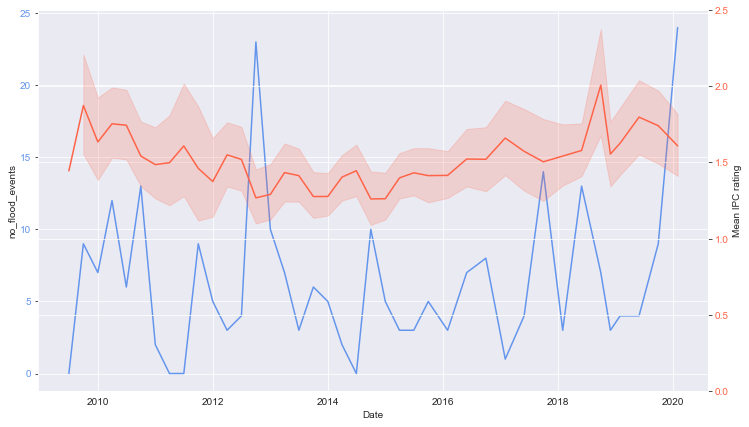

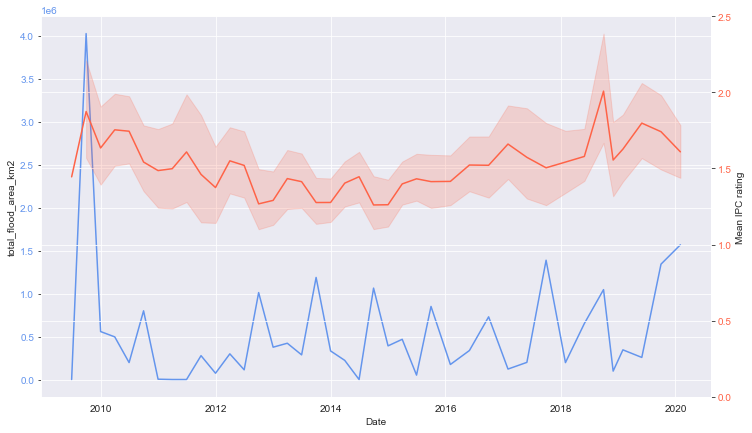

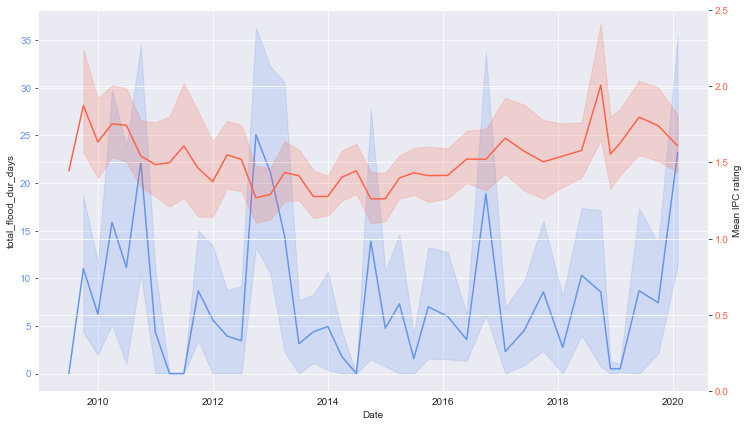

In [260]:
for i, cov in enumerate(covariates_0):

    fig, ax = plt.subplots(figsize = (12, 7))
    
    ax.tick_params(axis = 'y', labelcolor = 'cornflowerblue')

    sns.lineplot(x = "datetime_end", y = cov, data = df_national,
            ax = ax, estimator = estimators[i], ci = cis[i],
                color = 'cornflowerblue').set(xlabel = 'Date', ylabel = cov)
    
    ax2 = ax.twinx()
    ax2.set_ylabel('Mean IPC rating')
    ax2.set_ylim(0, 2.5)
    ax2.tick_params(axis = 'y', labelcolor = 'tomato')
    
    sns.lineplot(x = "datetime_end", y = 'mean_ipc', data = df_national,
                ax = ax2, estimator = 'mean', ci = 95,
                color = 'tomato').set(ylabel = 'Mean IPC rating')

    plt.show()